# 오디오 분류(Audio Classification)

* 가상 악기를 활용해 악기별 음색 데이터셋을 활용해 오디오 분류

1. 기존 데이터에서 분류에 사용되는 방법을 사용해 분류
2. 오디오 데이터에 특화된 분류

### 데이터 준비 및 전처리

In [1]:
import numpy as np
import itertools
import requests
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')

* 데이터를 저장할 리스트와 파일을 불러올 경로를 지정
* https://drive.google.com/uc?id=1ie8KQTfQQL-t4a_q6cLUYGz77lJn-JLg


In [2]:
path = './data/GeneralMidi.wav'

* wmv 파일에는 128개 악기와 46개 타악기의 음을 50개씩 2초 간격으로 존재
* 해당 예제에서는 일부 악기만 선택해서 사용

In [3]:
instruments = [10 * i for i in range(10)]
num_notes = 50
sec = 2

audio = []
inst = []
 
for inst_idx, note in itertools.product(range(len(instruments)), range(num_notes)):
    instrument = instruments[inst_idx]
    offset = instrument * num_notes * sec + note * sec
    print(f"Instrument: {instrument}, Note: {note}, Offset: {offset}")
    
    y, sr = librosa.load(path, sr=None, offset=offset, duration=float(sec))
    audio.append(y)
    inst.append(inst_idx)

Instrument: 0, Note: 0, Offset: 0
Instrument: 0, Note: 1, Offset: 2
Instrument: 0, Note: 2, Offset: 4
Instrument: 0, Note: 3, Offset: 6
Instrument: 0, Note: 4, Offset: 8
Instrument: 0, Note: 5, Offset: 10
Instrument: 0, Note: 6, Offset: 12
Instrument: 0, Note: 7, Offset: 14
Instrument: 0, Note: 8, Offset: 16
Instrument: 0, Note: 9, Offset: 18
Instrument: 0, Note: 10, Offset: 20
Instrument: 0, Note: 11, Offset: 22
Instrument: 0, Note: 12, Offset: 24
Instrument: 0, Note: 13, Offset: 26
Instrument: 0, Note: 14, Offset: 28
Instrument: 0, Note: 15, Offset: 30
Instrument: 0, Note: 16, Offset: 32
Instrument: 0, Note: 17, Offset: 34
Instrument: 0, Note: 18, Offset: 36
Instrument: 0, Note: 19, Offset: 38
Instrument: 0, Note: 20, Offset: 40
Instrument: 0, Note: 21, Offset: 42
Instrument: 0, Note: 22, Offset: 44
Instrument: 0, Note: 23, Offset: 46
Instrument: 0, Note: 24, Offset: 48
Instrument: 0, Note: 25, Offset: 50
Instrument: 0, Note: 26, Offset: 52
Instrument: 0, Note: 27, Offset: 54
Instrum

In [4]:
audio_np = np.array(audio, np.float32)
inst_np = np.array(inst, np.int16)

audio_np.shape, inst_np.shape

((500, 88200), (500,))

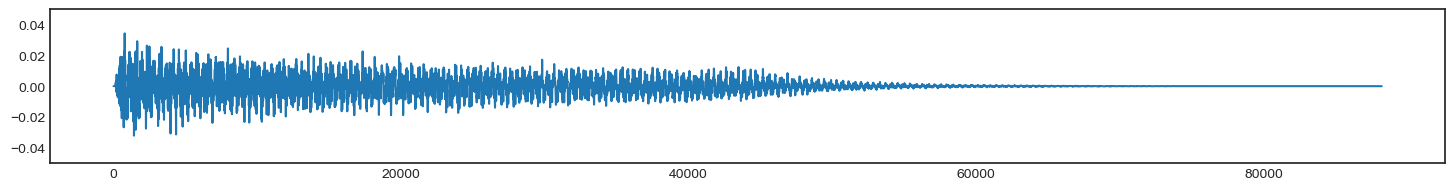

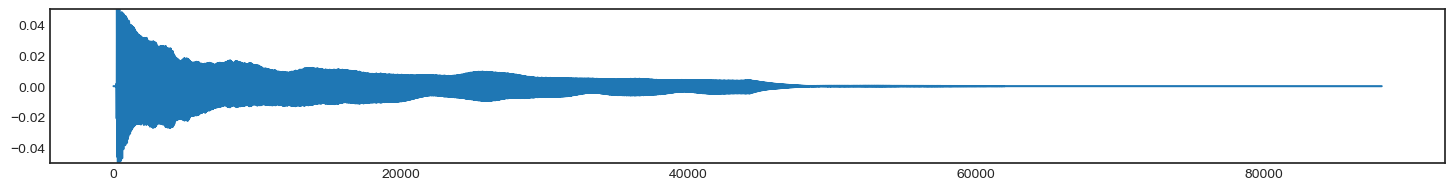

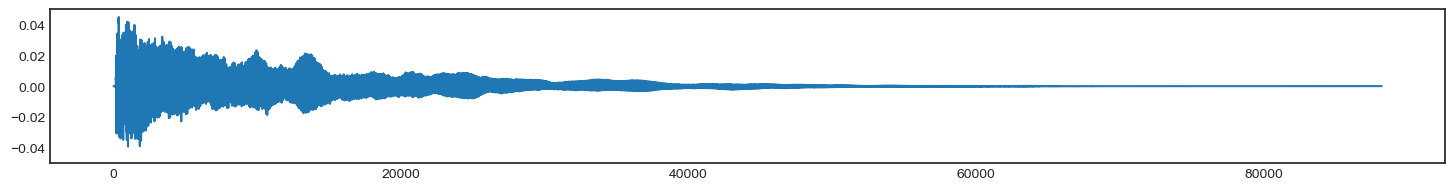

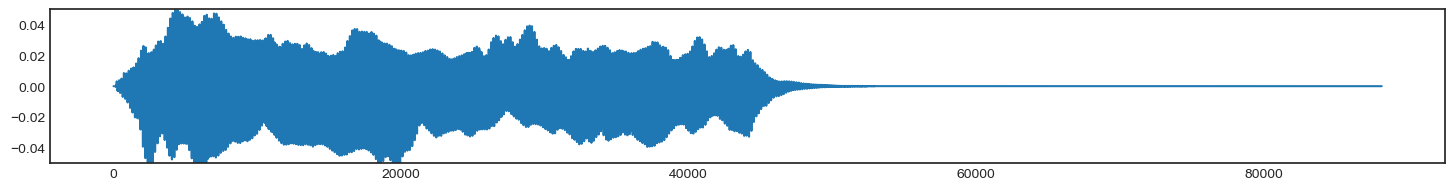

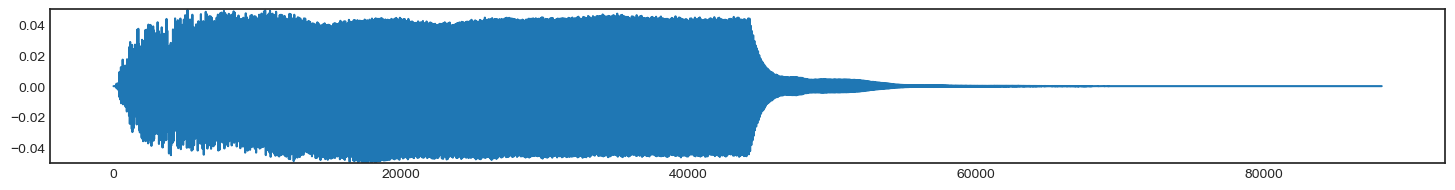

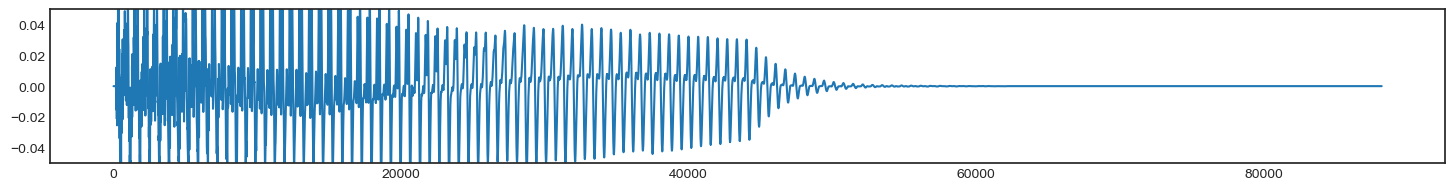

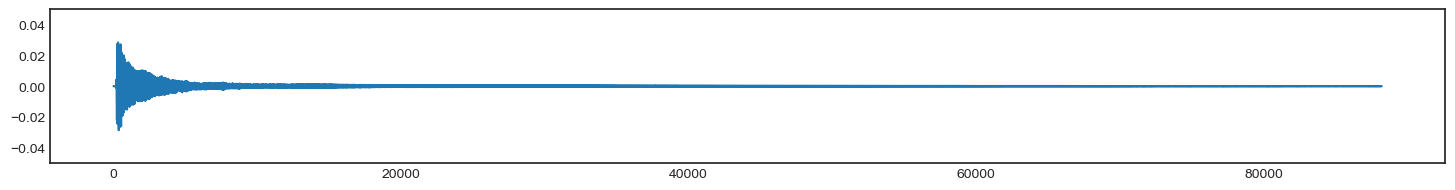

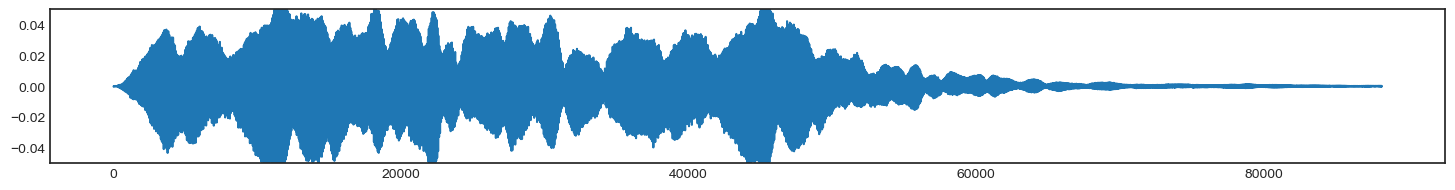

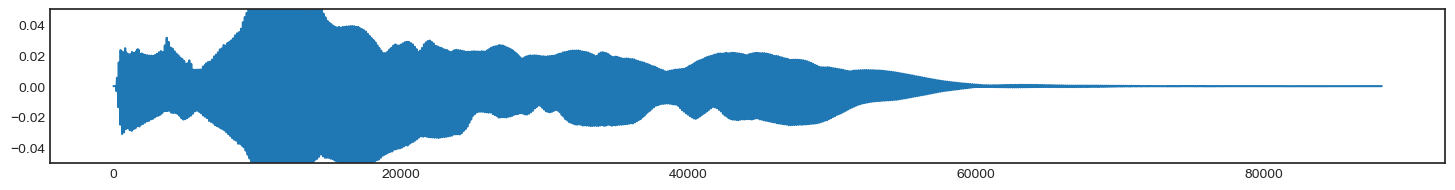

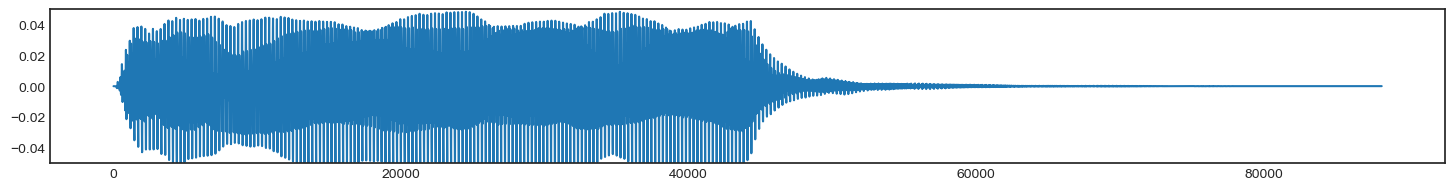

In [5]:
for idx in range(0, len(audio_np), num_notes):
    plt.figure(figsize=(18, 2))
    plt.plot(audio_np[idx])
    plt.ylim((-.05, .05))
    plt.show()

In [6]:
print(inst_np[0])
ipd.Audio(audio_np[0], rate=sr)

0


In [7]:
print(inst_np[50])
ipd.Audio(audio_np[50], rate=sr)

1


In [8]:
print(inst_np[100])
ipd.Audio(audio_np[100], rate=sr)

2


In [9]:
print(inst_np[150])
ipd.Audio(audio_np[150], rate=sr)

3


In [10]:
print(inst_np[200])
ipd.Audio(audio_np[200], rate=sr)

4


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
audio_np = scaler.fit_transform(audio_np)

## 머신러닝을 이용한 오디오 분류

* 학습 데이터와 실험 데이터를 분리

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(audio_np, inst_np, test_size=.2)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((400, 88200), (100, 88200), (400,), (100,))

### Logistic Regression

* Logistic Regression은 특성상 다중 분류에는 적합하지 않음

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
acc = accuracy_score(y_test, y_pred)

acc

c:\Users\kksoo\anaconda3\envs\torch\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.06

### Support Vector Machine

In [14]:
from sklearn.svm import SVC

svc = SVC(kernel='linear')
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
acc = accuracy_score(y_test, y_pred)

acc

0.07

### Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
acc = accuracy_score(y_test, y_pred)

acc

0.4

## Constant-Q를 이용한 머신러닝 오디오 분류

### Constant-Q 변환

- 음악과 오디오 분석에서 널리 사용되는 기술
- 주파수의 로그 스케일에 따라 신호를 분석하는 방법
- Fourier 변환의 일종으로 볼 수 있지만, Constant-Q 변환은 각 주파수 대역의 폭이 주파수에 비례하여 변한다는 점에서 차이가 있음
- 이러한 특성 때문에 음악 이론과 밀접하게 관련되어 있으며, 특히 서양 음악에서 12음계 체계와 잘 맞음

* wav는 매 순간의 음압을 측정하여 그 수치를 저장한 형태이기 때문에 그 자체로 음악을 분석하기에 적합하지 않음(음의 높이와 세기를 듣는것이지 순간의 음압을 듣는게 아니기 때문)
* 푸리에 변환과 같은 변환 기법을 이용하여 시간 축의 데이터를 주파수 축의 데이터로 바꿔줘야할 필요가 있음
* 푸리에 변환 대신 푸리에 변환과 유사한 Constant-Q 변환을 사용
* Constant-Q 변환은 주파수 축이 로그 단위로 변환되고, 각 주파수에 따라 해상도가 다양하게 처리되기 때문에(저주파는 저해상도, 고주파는 고해상도) 음악을 처리하는 데에 푸리에 변환보다 유리

* 주파수 대역을 저장할 리스트 `audio_cqt` 선언
* constant-Q 변환할 때는 변환할 오디오 데이터와 sampling rate가 필요
* 해당 데이터에서는 sampling rate가 모두 동일하므로 따로 처리가 필요하지 않음
* Constant-Q 변환을 사용해 오디오 데이터를 주파수 대역으로 변환




*   변환에는 앞서 준비한 데이터를 가져와 사용하며, Constant-Q 변환에는 `librosa.cqt` 함수를 사용
*   여기서 `n_bins`는 옥타브 단계 및 개수를, `bins_per_octave`는 한 옥타브가 가지는 단계를 의미
*   라벨에 대해선 원 핫 인코딩을 적용



In [16]:
audio_cqt = []

for y in audio:
    ret = librosa.cqt(y=y, sr=sr, hop_length=1_024, n_bins=24*7, bins_per_octave=24)
    ret = np.abs(ret)
    audio_cqt.append(ret)

* 앞서 생성한 주파수 대역을 spectrogram으로 시각화
* 악기 간 spectrogram을 비교해보면 차이가 존재함을 알 수 있음

C:\Users\kksoo\AppData\Local\Temp\ipykernel_19260\3668530378.py:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')


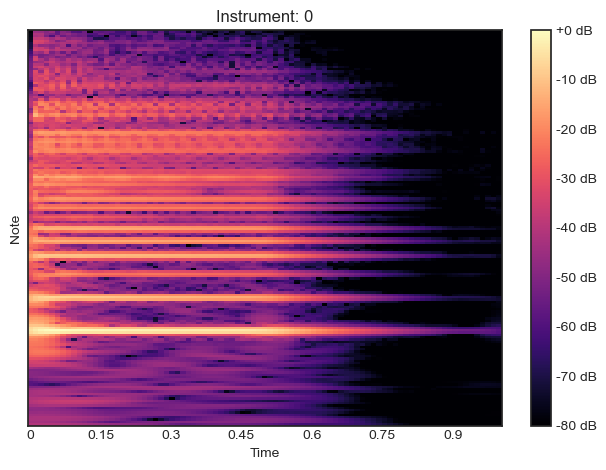

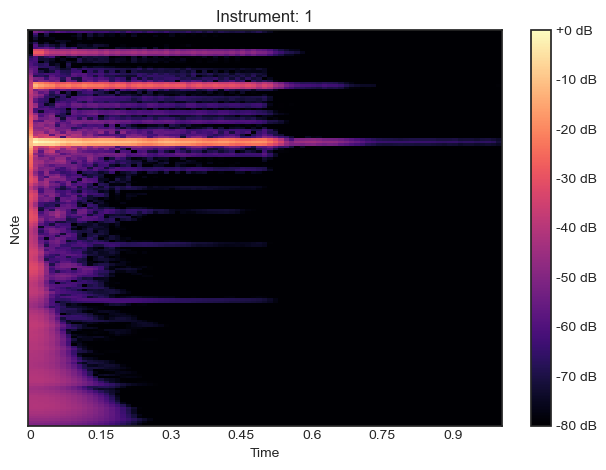

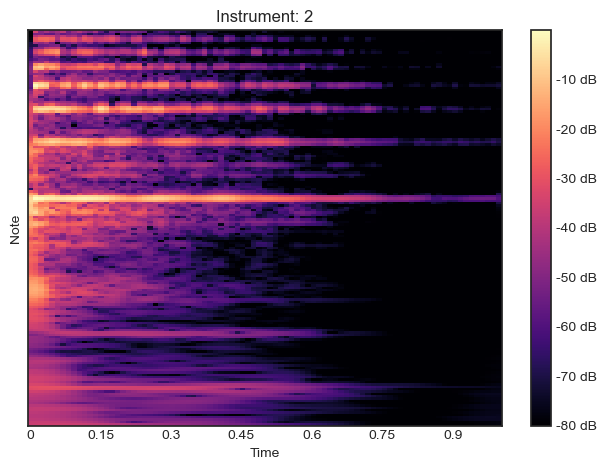

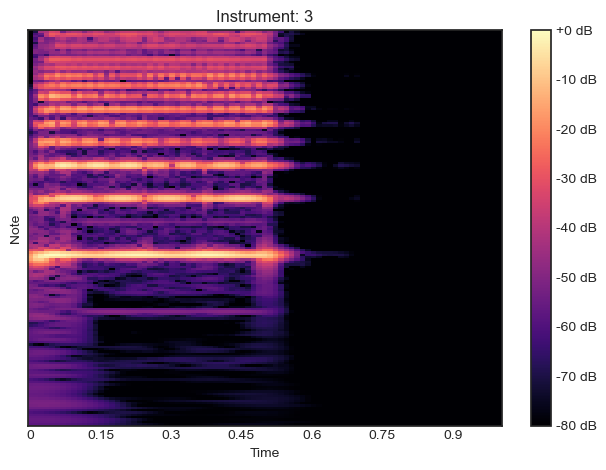

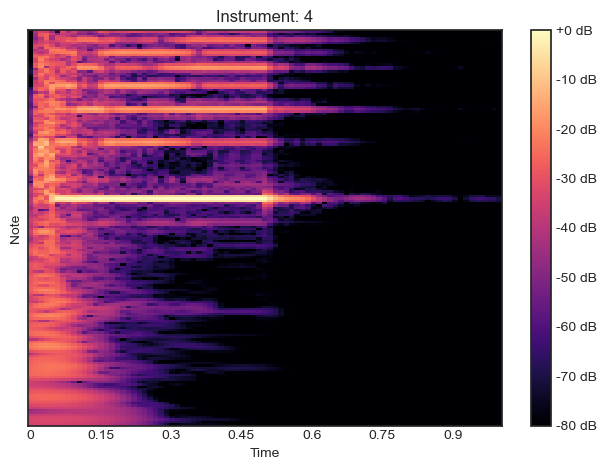

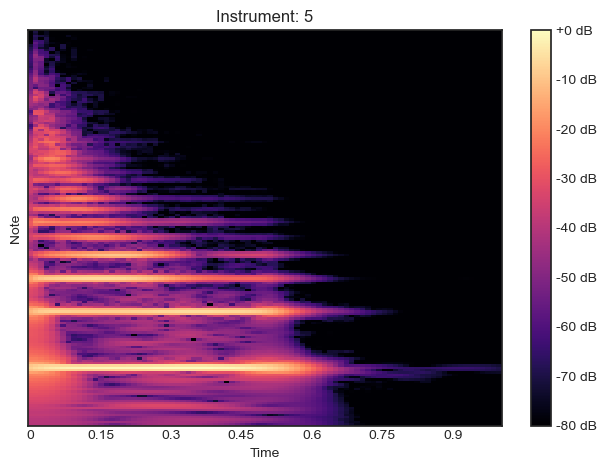

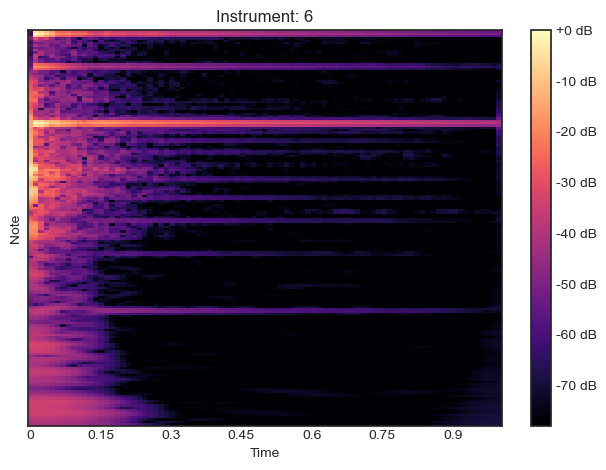

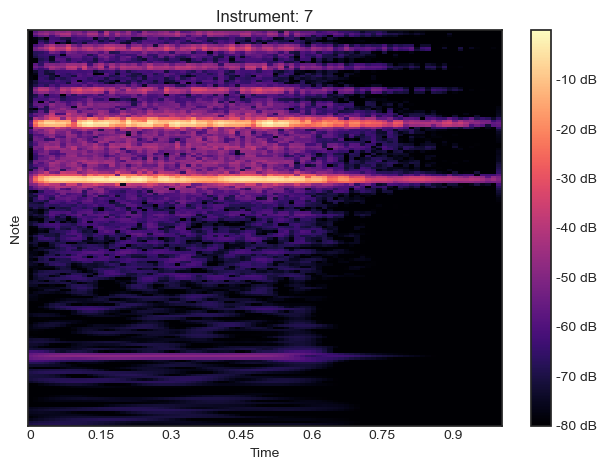

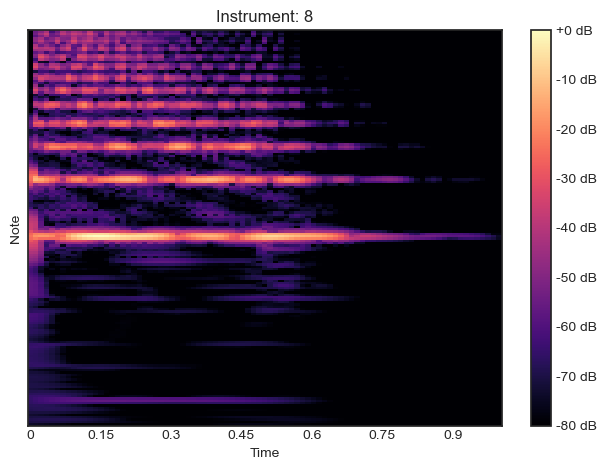

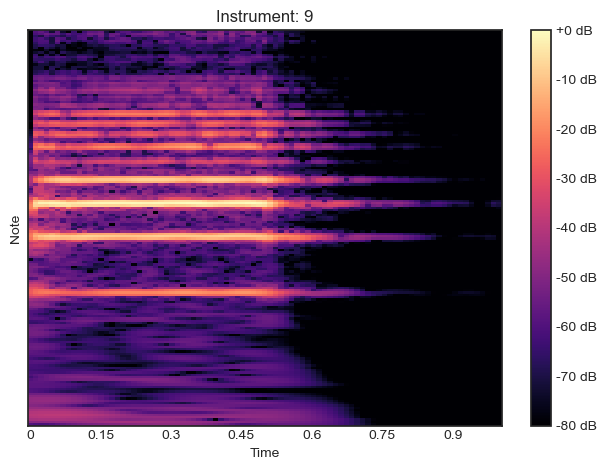

In [17]:
for i in range(0, len(instruments) * num_notes, num_notes):
    amp_db = librosa.amplitude_to_db(np.abs(audio_cqt[i]), ref=np.max)
    librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Instrument: {inst[i]}')
    plt.tight_layout()
    plt.show()

* 훈련 데이터와 실험 데이터를 분리

In [18]:
cqt_np = np.array(audio_cqt, np.float32)
inst_np = np.array(inst, np.int16)

cqt_np.shape, inst_np.shape

((500, 168, 87), (500,))



*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환



In [19]:
cqt_np = cqt_np.reshape((500, -1))



*   읽어온 데이터는 음량이나 범위가 다를 수 있음
*   min-max scaling을 통해 데이터의 범위를 조정함



In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cqt_np = scaler.fit_transform(cqt_np)

* 학습 데이터와 실험 데이터를 분리

In [21]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(cqt_np, inst_np, test_size=.2)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((400, 14616), (100, 14616), (400,), (100,))

### Logistic Regression

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
acc = accuracy_score(y_test, y_pred)

acc

0.61

### Support Vector Machine

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
acc = accuracy_score(y_test, y_pred)

acc

0.43

### Decision Tree

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
acc = accuracy_score(y_test, y_pred)

acc

0.71

## Constant-Q 특징을 이용한 딥러닝 오디오 분류

* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### DNN 모델 구성

In [188]:
cqt_np = np.array(audio_cqt, np.float32).reshape((500, -1))
cqt_arr = np.expand_dims(cqt_np, -1)
inst_cat = inst_np
x_train, x_test, y_train, y_test = train_test_split(cqt_arr, inst_cat, test_size=.2)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((400, 14616, 1), (100, 14616, 1), (400,), (100,))

In [189]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

x_train = torch.tensor(x_train).unsqueeze(1)
x_test = torch.tensor(x_test).unsqueeze(1)
y_train = torch.tensor(y_train).long()
y_test = torch.tensor(y_test).long()

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [190]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc_1 = nn.Linear(14616, 512)
        self.fc_2 = nn.Linear(512, 256)
        self.fc_3 = nn.Linear(256, 128)
        self.fc_4 = nn.Linear(128, 10)
        
    def forward(self, x: torch.Tensor):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = F.relu(self.fc_3(x))
        x = self.fc_4(x)
        
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)

In [191]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [192]:
for epoch in range(30):
    running_loss = .0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        iter_size = len(train_loader)
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if i % iter_size == iter_size - 1:
            print(f"Epoch: {epoch + 1}, Loss: {running_loss / (i + 1)}")
            running_loss = .0

Epoch: 1, Loss: 2.187818710620587
Epoch: 2, Loss: 1.7743883041235118
Epoch: 3, Loss: 1.2729213879658625
Epoch: 4, Loss: 0.9529373278984656
Epoch: 5, Loss: 0.7466949980992538
Epoch: 6, Loss: 0.5822598911248721
Epoch: 7, Loss: 0.4153932516391461
Epoch: 8, Loss: 0.40272577794698566
Epoch: 9, Loss: 0.35356871210611784
Epoch: 10, Loss: 0.2988973099451799
Epoch: 11, Loss: 0.20160601001519424
Epoch: 12, Loss: 0.15875993726345208
Epoch: 13, Loss: 0.1234589283569501
Epoch: 14, Loss: 0.08906164679389733
Epoch: 15, Loss: 0.07336265479142849
Epoch: 16, Loss: 0.06464945607317182
Epoch: 17, Loss: 0.05983182039255133
Epoch: 18, Loss: 0.052070572829017274
Epoch: 19, Loss: 0.04866988278137377
Epoch: 20, Loss: 0.045174945280170783
Epoch: 21, Loss: 0.047521455213427544
Epoch: 22, Loss: 0.042628733727794424
Epoch: 23, Loss: 0.04222067481336685
Epoch: 24, Loss: 0.03756414457725791
Epoch: 25, Loss: 0.03902396802396442
Epoch: 26, Loss: 0.03565585444896267
Epoch: 27, Loss: 0.0351147286934205
Epoch: 28, Loss: 

In [194]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inps, labels = data[0].to(device), data[1].to(device)
        outputs = net(inps)
        pred_vals, pred_indices = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (pred_indices == labels).sum().item()

print(100 * correct / total)

58.0


### CNN 모델 구성



*   spectrogram을 분류할 CNN 모델 구성
*   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
*   spectrogram은 1차원 이미지로 간주


In [257]:
cqt_np = np.array(audio_cqt, np.float32)
cqt_arr = np.expand_dims(cqt_np, 1)
inst_cat = inst_np

x_train, x_test, y_train, y_test = train_test_split(cqt_arr, inst_cat, test_size=.2)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((400, 1, 168, 87), (100, 1, 168, 87), (400,), (100,))

In [258]:
x_train = torch.tensor(x_train)
x_test = torch.tensor(x_test)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [259]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = nn.Conv2d(1, 128, 3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv_3 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        
        self.dropout = nn.Dropout(.5)
        
        self.fc_1 = nn.Linear(512 * 21 * 10, 512)
        self.fc_2 = nn.Linear(512, 256)
        self.fc_3 = nn.Linear(256, 128)
        self.fc_4 = nn.Linear(128, 10)
        
    def forward(self, x: torch.Tensor):
        x = F.max_pool2d(F.relu(self.conv_1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv_2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv_3(x)), (2, 2))
        
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc_1(x))
        x = self.dropout(x)
        x = F.relu(self.fc_2(x))
        x = self.dropout(x)
        x = F.relu(self.fc_3(x))
        x = self.dropout(x)
        x = self.fc_4(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        
        for s in size:
            num_features *= s
            
        return num_features

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)

In [260]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [261]:
for epoch in range(300):
    running_loss = .0
    
    for idx, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if idx % len(train_loader) == len(train_loader) - 1:
            print(f"Epoch: {epoch + 1}, Loss: {running_loss / (idx + 1)}")
            running_loss = .0

Epoch: 1, Loss: 2.3243140257321873
Epoch: 2, Loss: 2.3040750393500695
Epoch: 3, Loss: 2.302824277144212
Epoch: 4, Loss: 2.2917976012596717
Epoch: 5, Loss: 2.235132474165696
Epoch: 6, Loss: 2.1110593447318444
Epoch: 7, Loss: 2.008863935103783
Epoch: 8, Loss: 1.8381853195337148
Epoch: 9, Loss: 1.700135038449214
Epoch: 10, Loss: 1.6524546513190637
Epoch: 11, Loss: 1.5031161858485296
Epoch: 12, Loss: 1.4002430255596454
Epoch: 13, Loss: 1.357557406792274
Epoch: 14, Loss: 1.2564529547324548
Epoch: 15, Loss: 1.1563467383384705
Epoch: 16, Loss: 1.0644443952120268
Epoch: 17, Loss: 0.9064571628203759
Epoch: 18, Loss: 0.8197789283899161
Epoch: 19, Loss: 0.7039117996509259
Epoch: 20, Loss: 0.6031898649839255
Epoch: 21, Loss: 0.5381087546165173
Epoch: 22, Loss: 0.38969342295940107
Epoch: 23, Loss: 0.35741863342431873
Epoch: 24, Loss: 0.4038682155884229
Epoch: 25, Loss: 0.3079085292724463
Epoch: 26, Loss: 0.32287839914743716
Epoch: 27, Loss: 0.2875992856346644
Epoch: 28, Loss: 0.3179112053834475
Epo



*   훈련한 모델에 대한 정확도 평가
*   앞선 일반 분류 방법보다 정확도가 많이 오른 것을 확인할 수 있음



In [262]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        imgs, labels = data[0].to(device), data[1].to(device)
        outputs = net(imgs)
        pred_vals, pred_indices = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (pred_indices == labels).sum().item()
    
print(100 * correct / total)

96.0


## MFCC를 이용한 머신러닝 오디오 분류

### 데이터 준비

* 데이터를 불러오고 MFCC(Mel-frequency cepstral coefficients)를 사용해 melspectrogram으로 변환

In [107]:
audio_mfcc = []

for y in audio:
    ret = librosa.feature.mfcc(y=y, sr=sr)
    audio_mfcc.append(ret)

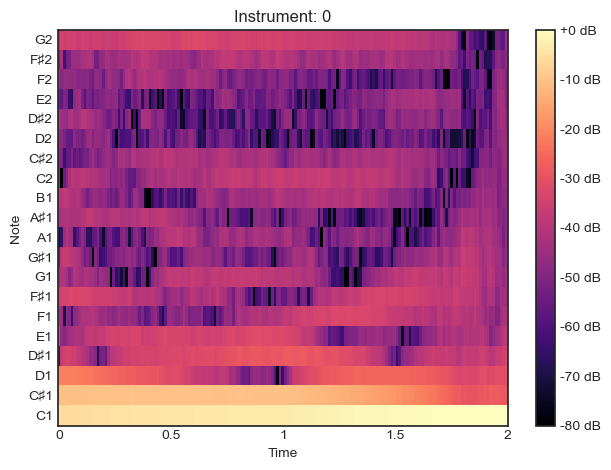

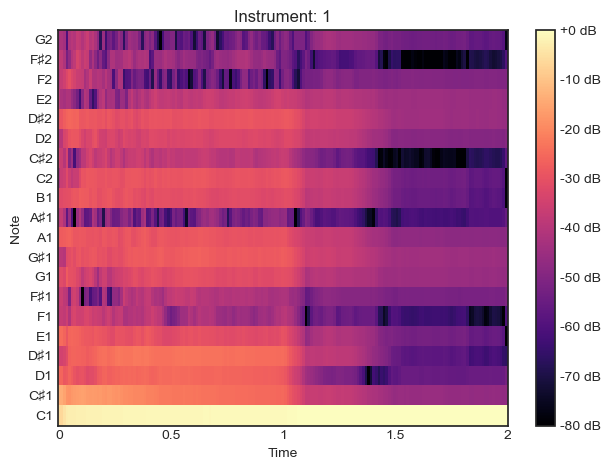

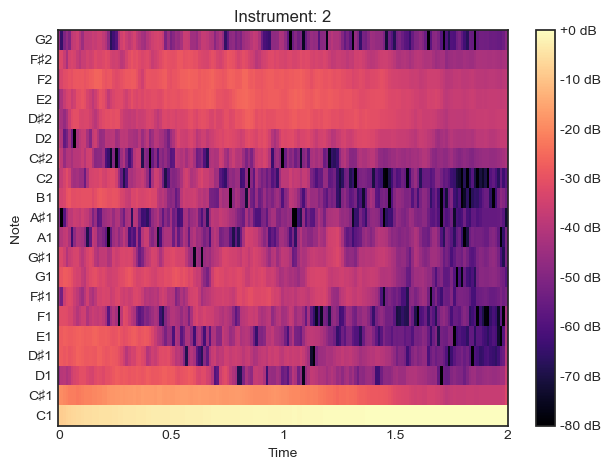

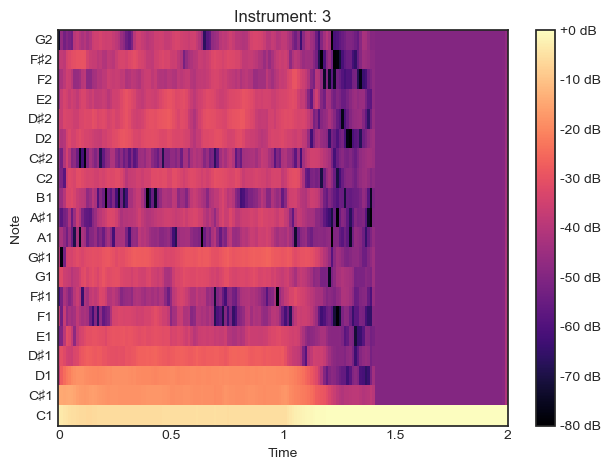

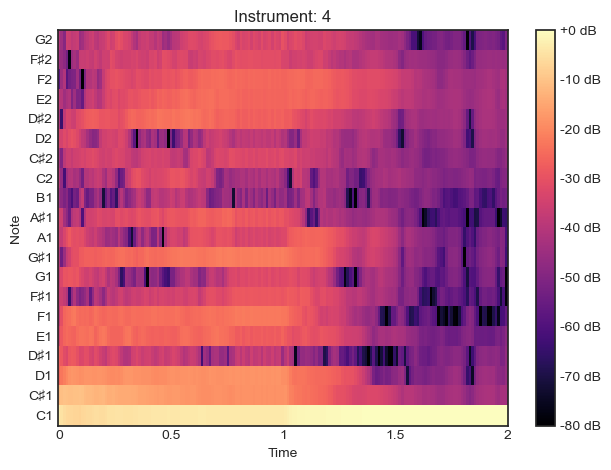

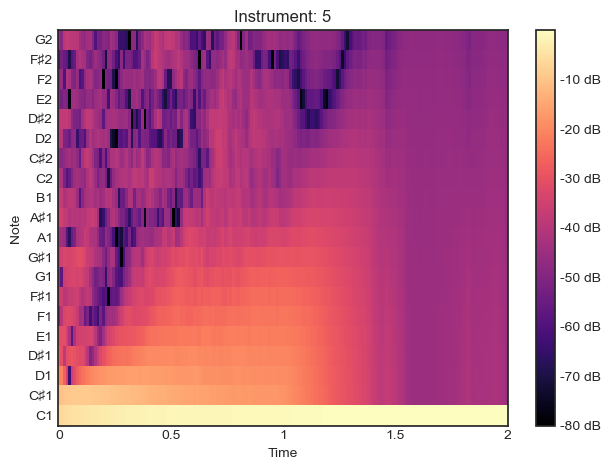

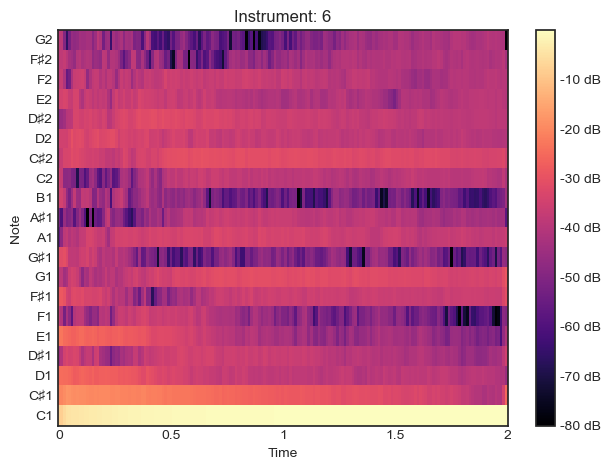

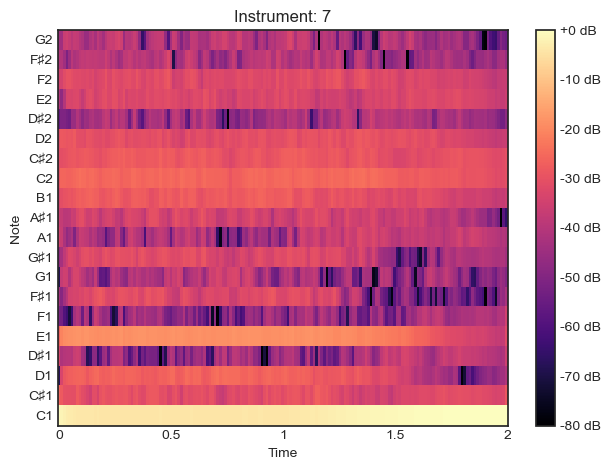

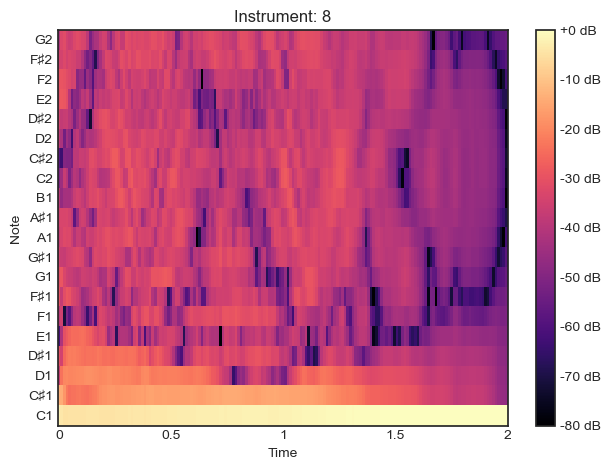

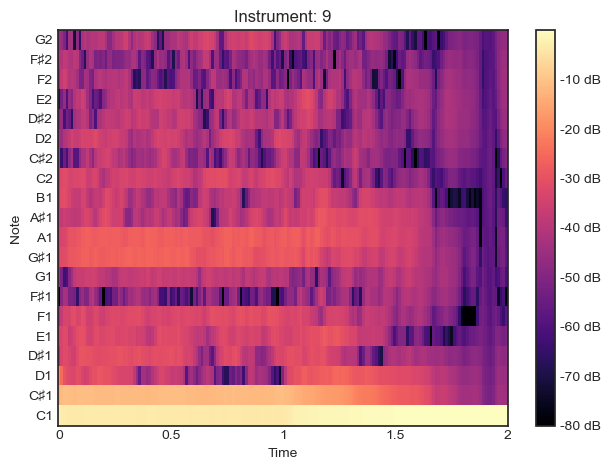

In [112]:
for i in range(0, len(instruments)*num_notes, num_notes):
    amp_db = librosa.amplitude_to_db(np.abs(audio_mfcc[i]), ref=np.max)
    librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Instrument: {inst[i]}")
    plt.tight_layout()
    plt.show()

In [117]:
mfcc_np = np.array(audio_mfcc, np.float32)
inst_np = np.array(inst, np.int16)

mfcc_np.shape, inst_np.shape

((500, 20, 173), (500,))



*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환



In [118]:
mfcc_np = mfcc_np.reshape((500, -1))



*   읽어온 데이터는 음량이나 범위가 다를 수 있음
*   min-max scaling을 통해 데이터의 범위를 조정함



In [119]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
mfcc_np = scaler.fit_transform(mfcc_np)

* 학습 데이터와 실험 데이터를 분리

In [120]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(mfcc_np, inst_np, test_size=.2)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((400, 3460), (100, 3460), (400,), (100,))

### Logistic Regression

In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
acc = accuracy_score(y_test, y_pred)

acc

c:\Users\kksoo\anaconda3\envs\torch\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.99

### Support Vector Machine

In [123]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
acc = accuracy_score(y_test, y_pred)

acc

0.97

### Decision Tree

In [124]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
acc = accuracy_score(y_test, y_pred)

acc

0.91

## MFCC를 이용한 딥러닝 오디오 분류

* 앞선 문제점을 극복하기 위해 오디오 데이터에 특화된 분류 방법 필요
* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### DNN 모델 구성

In [205]:
mfcc_np = np.array(audio_mfcc, np.float32).reshape(500, -1)
mfcc_arr = np.expand_dims(mfcc_np, -1)
inst_cat = inst_np

x_train, x_test, y_train, y_test = train_test_split(mfcc_arr, inst_cat, test_size=.2)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((400, 3460, 1), (100, 3460, 1), (400,), (100,))

In [206]:
x_train = torch.tensor(x_train).unsqueeze(1)
x_test = torch.tensor(x_test).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [207]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc_1 = nn.Linear(3460, 512)
        self.fc_2 = nn.Linear(512, 256)
        self.fc_3 = nn.Linear(256, 128)
        self.fc_4 = nn.Linear(128, 10)

    def forward(self, x: torch.Tensor):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = F.relu(self.fc_3(x))
        x =  self.fc_4(x)
        
        return x

net = Net().to(device)

In [208]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [209]:
for epoch in range(30):
    running_loss = .0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        iter_size = len(train_loader)
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if i % iter_size == iter_size - 1:
            print(f"Epoch: {epoch + 1}, Loss: {running_loss / (i + 1)}")
            running_loss = .0

Epoch: 1, Loss: 27.57212081322303
Epoch: 2, Loss: 4.887704409085787
Epoch: 3, Loss: 1.8956739352299616
Epoch: 4, Loss: 0.8856324691038865
Epoch: 5, Loss: 0.5872085919746985
Epoch: 6, Loss: 0.5156685732878171
Epoch: 7, Loss: 0.2722285808278964
Epoch: 8, Loss: 0.23695219193513578
Epoch: 9, Loss: 0.2057613214621177
Epoch: 10, Loss: 0.1708640315784858
Epoch: 11, Loss: 0.12139055777627689
Epoch: 12, Loss: 0.1031574675670037
Epoch: 13, Loss: 0.07265125974439658
Epoch: 14, Loss: 0.07713980772174321
Epoch: 15, Loss: 0.06721320318487975
Epoch: 16, Loss: 0.05449535232037306
Epoch: 17, Loss: 0.05619287555320905
Epoch: 18, Loss: 0.13642321928189352
Epoch: 19, Loss: 0.11987830712818183
Epoch: 20, Loss: 0.0981572733905453
Epoch: 21, Loss: 0.07521428984518234
Epoch: 22, Loss: 0.04333652681312882
Epoch: 23, Loss: 0.08095397244995603
Epoch: 24, Loss: 0.04466633867615691
Epoch: 25, Loss: 0.03704386362089561
Epoch: 26, Loss: 0.05113061567625174
Epoch: 27, Loss: 0.03503454883153049
Epoch: 28, Loss: 0.0292

In [210]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inps, labels = data[0].to(device), data[1].to(device)
        outputs = net(inps)
        pred_vals, pred_indices = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (pred_indices == labels).sum().item()

print(100 * correct / total)

95.0


### CNN 모델 구성

In [263]:
mfcc_np = np.array(audio_mfcc, np.float32)
mfcc_np = np.expand_dims(mfcc_np, 1)
inst_cat = inst_np

x_train, x_test, y_train, y_test = train_test_split(mfcc_np, inst_cat, test_size=.2)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((400, 1, 20, 173), (100, 1, 20, 173), (400,), (100,))

In [264]:
x_train = torch.tensor(x_train)
x_test = torch.tensor(x_test)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)



*   spectrogram을 분류할 CNN 모델 구성
*   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
*   spectrogram은 1차원 이미지로 간주


In [265]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = nn.Conv2d(1, 128, 3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv_3 = nn.Conv2d(256, 512, 3, stride=1, padding=1)

        self.max_pool = nn.MaxPool2d(2)

        self.dropout = nn.Dropout(.5)

        self.flatten = nn.Flatten()
        
        self.fc_1 = nn.Linear(512 * 2 * 21, 512)
        self.fc_2 = nn.Linear(512, 256)
        self.fc_3 = nn.Linear(256, 128)
        self.fc_4 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_2(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_3(x))
        x = self.max_pool(x)

        x = self.flatten(x)
        
        x = F.relu(self.fc_1(x))
        x = self.dropout(x)
        x = F.relu(self.fc_2(x))
        x = self.dropout(x)
        x = F.relu(self.fc_3(x))
        x = self.dropout(x)
        x = self.fc_4(x)

        return x
    
net = Net().to(device)

In [266]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [267]:
for epoch in range(300):
    running_loss = .0
    
    for idx, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        if idx % len(train_loader) == len(train_loader) - 1:
            print(f"Epoch: {epoch + 1}, Loss: {running_loss / (idx + 1)}")
            running_loss = .0

Epoch: 1, Loss: 7.426906108856201
Epoch: 2, Loss: 2.314522706545316
Epoch: 3, Loss: 2.289803670002864
Epoch: 4, Loss: 2.2461058359879713
Epoch: 5, Loss: 2.1612379734332743
Epoch: 6, Loss: 2.1576098845555234
Epoch: 7, Loss: 2.07631372488462
Epoch: 8, Loss: 1.988203186255235
Epoch: 9, Loss: 1.921842098236084
Epoch: 10, Loss: 1.8183564864672148
Epoch: 11, Loss: 1.8841099097178533
Epoch: 12, Loss: 1.851678178860591
Epoch: 13, Loss: 1.8082835857684796
Epoch: 14, Loss: 1.7158123804972722
Epoch: 15, Loss: 1.6269335196568415
Epoch: 16, Loss: 1.5654149238879864
Epoch: 17, Loss: 1.6022204068990855
Epoch: 18, Loss: 1.562045931816101
Epoch: 19, Loss: 1.4120117701016939
Epoch: 20, Loss: 1.4189347074582026
Epoch: 21, Loss: 1.452419060927171
Epoch: 22, Loss: 1.3555597112728999
Epoch: 23, Loss: 1.257466508791997
Epoch: 24, Loss: 1.2794923415550818
Epoch: 25, Loss: 1.2936805853476891
Epoch: 26, Loss: 1.2838172820898204
Epoch: 27, Loss: 1.1702459087738624
Epoch: 28, Loss: 1.1697564858656664
Epoch: 29, L

In [268]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        pred_vals, pred_indices = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (pred_indices == labels).sum().item()
    
print(100 * correct / total)

96.0
